In [ ]:
!pip install opensmile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.2/996.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=168840 sha256=9f2195ad5aa717cc4fc89f2167f7cb6cebaf0e3a2324f8798e82cde2208d318b
  Stored in directory: /root/.cache/pip/wheels/d8/78/cc/5478ca3b1c3f602eae6f8cdbd78f909c0a0bfa0bbcb5c7771f
Successfully built iso-639


In [5]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle username:Your Kaggle username:Your Kaggle username:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import opensmile
import pandas as pd
from tqdm import tqdm
import random

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

emotions_dict = { '01': 'positive', '02': 'positive',  '03': 'positive', '04':'negative', '05': 'negative', '06': 'negative', '07':'negative', '08': 'positive'}
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

df = pd.DataFrame()
addrs = []
labels = []
import os
for dirname, _, filenames in os.walk('/content/ravdess-emotional-speech-audio/audio_speech_actors_01-24'):
    for filename in filenames:
        addr = os.path.join(dirname, filename)
        emotion = emotions_dict[addr.split('-')[6]]
        gender = addr.split('-')[-1].split('.')[0]
        # if(int(gender) % 2 == 0): continue
        addrs.append(addr)
        labels.append(emotion)

df['addr'] = addrs
df['label'] = labels
max_length = 0
for i in tqdm(range(df.shape[0])):
    max_length = max(max_length, librosa.load(df['addr'][i])[0].shape[0])

0it [00:00, ?it/s]


In [3]:
'/content/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav'.split('-')[-1].split('.')[0]

'01'

In [3]:
from sklearn.preprocessing import OneHotEncoder
all_labels = np.array([label for label in df['label']]).reshape(-1, 1)
one_hot = OneHotEncoder(sparse_output = False)
one_hot.fit(all_labels)
y = one_hot.transform(np.array(labels).reshape(-1, 1))
y_train = y[:-240]
y_valid = y[-240:]

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [4]:
columns = [ 'F0semitoneFrom27.5Hz_sma3nz_amean',
'shimmerLocaldB_sma3nz_amean',
'HNRdBACF_sma3nz_amean',
'MeanUnvoicedSegmentLength',
'MeanVoicedSegmentLengthSec',
'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
'jitterLocal_sma3nz_stddevNorm',
'shimmerLocaldB_sma3nz_stddevNorm',
'StddevVoicedSegmentLengthSec',
'StddevUnvoicedSegmentLength',
'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
'spectralFluxV_sma3nz_amean',
]

Using just F0 statistics yields around 65% accuracy in the random forest model. \
Using just the 5 base features yields around 65% accuracy in the random forest and around 56% in the decision tree model. \
Using all the features yields 60% accuracy in the decsion tree model and close to 70% accuracy in the random forest and xgboost models.

**Decsion Tree**

In [5]:
x = pd.read_csv('features.csv', index_col = 0)

In [ ]:
# x_train = feature_set[:-240, :]
# x_valid = feature_set[-240:, :]
# y_train = df['label'][:-240]
# y_valid = df['label'][-240:]

In [6]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier

np.random.seed(50)
# Define the number of folds
k_folds = 5
kf = KFold(n_splits = k_folds, shuffle = True, random_state=42)
model = DecisionTreeClassifier()
# Perform k-fold cross-validation
scores = cross_val_score(model, x[columns], x['label'], cv=kf)

# Print the average score and standard deviation
print("Average Score:", scores.mean())
print("Standard Deviation:", scores.std())

Average Score: 0.6368055555555555
Standard Deviation: 0.011326046132152842


In [ ]:
# importances = []
# for i in range(len(list(x.columns[:-1]))):
#   importances.append((model.feature_importances_[i], x.columns[i]))
# importances.sort(reverse = True)
# columns = []
# for i in range(10):
#   columns.append(importances[i][1])
# columns

AttributeError: 'DecisionTreeClassifier' object has no attribute 'classes_'

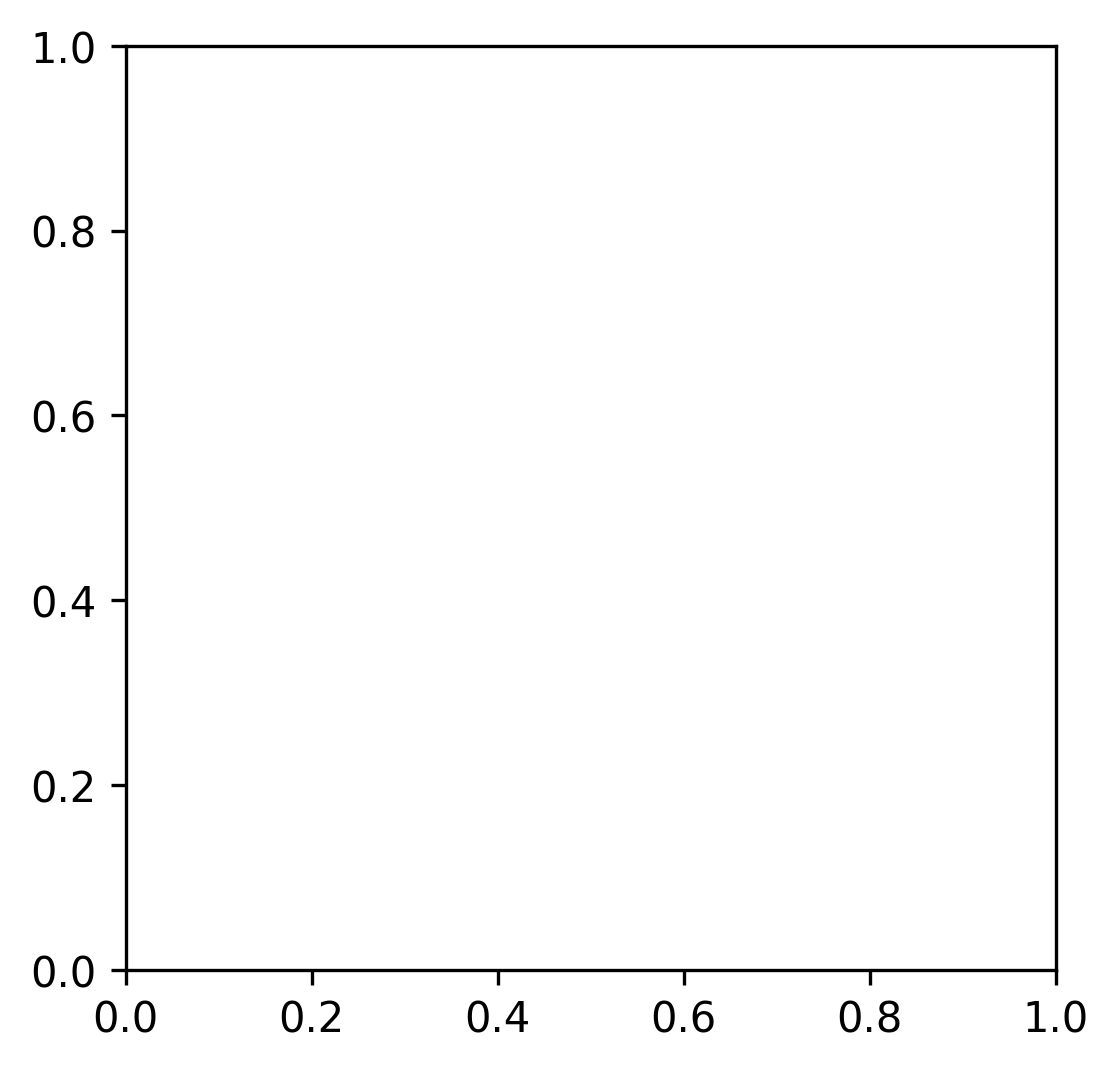

In [7]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 300)
fn = columns
cn = model.classes_
tree.plot_tree(model,
               feature_names = fn,
               class_names=cn,
               filled = True)

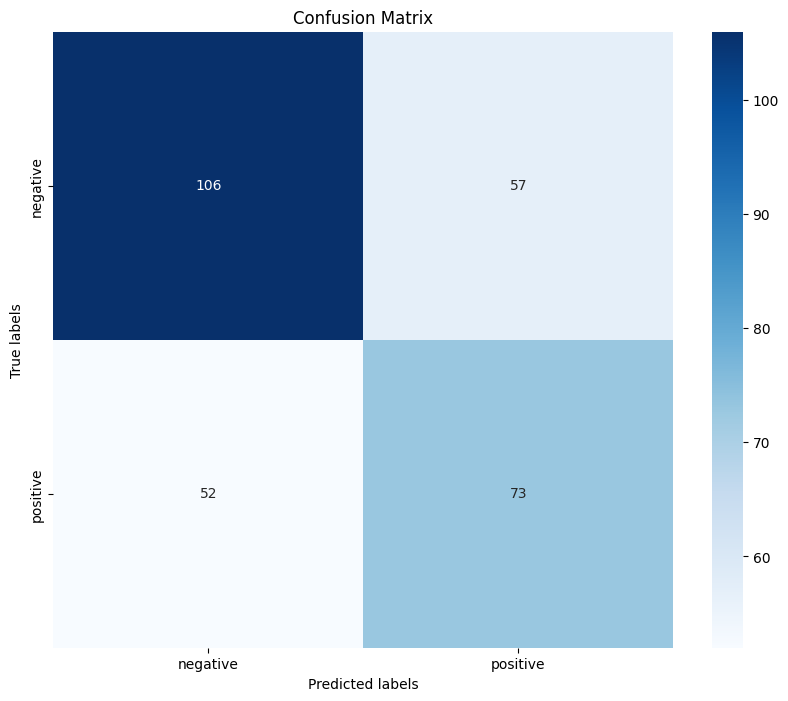

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Use the model to predict the labels for the validation set
x_train, x_valid, y_train, y_valid = train_test_split(x[columns], x['label'], train_size = 0.8)
model = DecisionTreeClassifier(random_state = 50)
model.fit(x_train, y_train)
model.score(x_valid, y_valid)

# Calculate the confusion matrix
cm = confusion_matrix(y_valid, model.predict(x_valid))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import recall_score
recall = recall_score(y_valid, model.predict(x_valid), average = 'weighted')
recall

0.6215277777777778

In [ ]:
from sklearn.metrics import precision_score
precision = precision_score(y_valid, model.predict(x_valid), average = 'weighted')
precision

0.6234261738613005

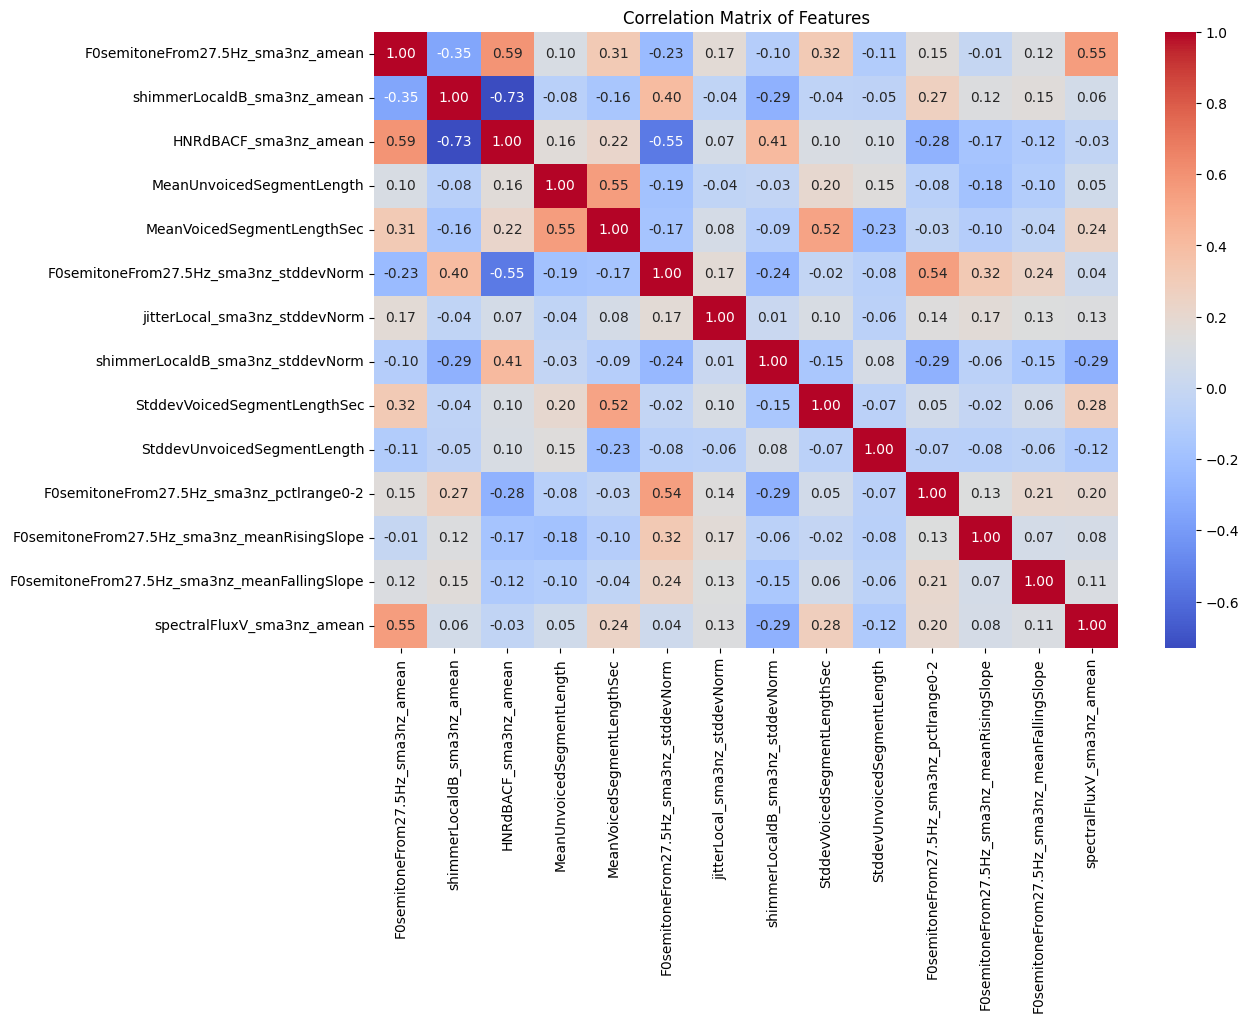

In [ ]:
# Assuming x_train is a pandas DataFrame
correlation_matrix = x[columns].corr()


# If you want to visualize the correlation matrix, you can use a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(50)
# Define the number of folds
k_folds = 5
kf = KFold(n_splits = k_folds, shuffle = True, random_state = 42)
model = RandomForestClassifier()
# Perform k-fold cross-validation
scores = cross_val_score(model, x[columns], x['label'], cv=kf)

# Print the average score and standard deviation
print("Average Score:", scores.mean())
print("Standard Deviation:", scores.std())

Average Score: 0.7291666666666666
Standard Deviation: 0.022715871158050176


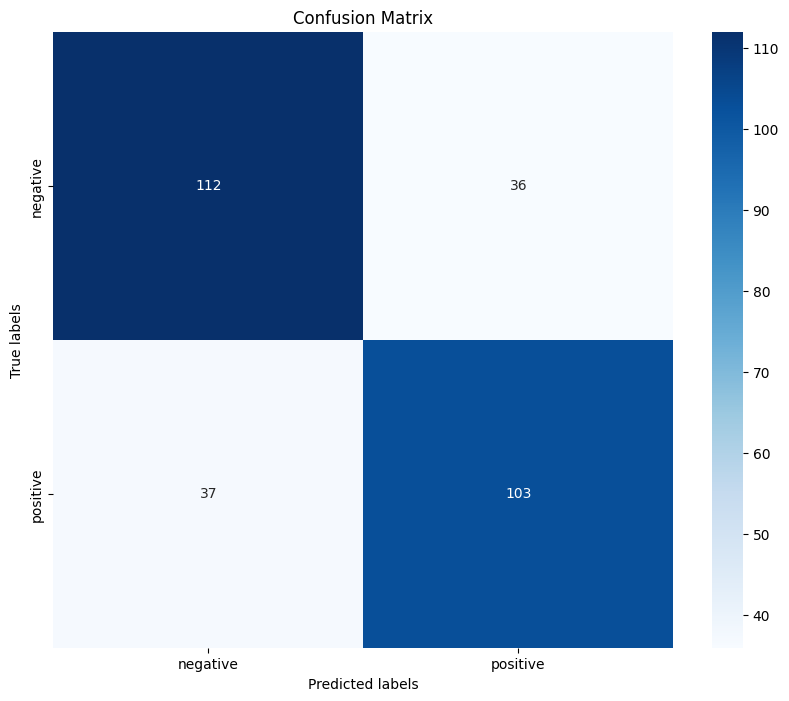

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x[columns], x['label'], train_size = 0.8)
model = RandomForestClassifier(random_state = 50)
model.fit(x_train, y_train)

cm = confusion_matrix(y_valid, model.predict(x_valid))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
for i in range(len(columns)):
  print("{} {}".format(columns[i], model.feature_importances_[i]))

F0semitoneFrom27.5Hz_sma3nz_amean 0.06894217135696937
shimmerLocaldB_sma3nz_amean 0.05505907902395398
HNRdBACF_sma3nz_amean 0.06369202276877069
MeanUnvoicedSegmentLength 0.05544346129641434
MeanVoicedSegmentLengthSec 0.05642369679839725
F0semitoneFrom27.5Hz_sma3nz_stddevNorm 0.06999992209547666
jitterLocal_sma3nz_stddevNorm 0.05920396576578374
shimmerLocaldB_sma3nz_stddevNorm 0.0688803271313244
StddevVoicedSegmentLengthSec 0.06446007675744563
StddevUnvoicedSegmentLength 0.06397631807807884
F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2 0.08909035660210553
F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope 0.0898871554518777
F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope 0.08160368052627495
spectralFluxV_sma3nz_amean 0.11333776634712697


In [ ]:
from sklearn.metrics import recall_score
recall = recall_score(y_valid, model.predict(x_valid), average = 'weighted')
recall

0.7465277777777778

In [ ]:
from sklearn.metrics import precision_score
precision = precision_score(y_valid, model.predict(x_valid), average = 'weighted')
precision

0.7464907268815819

**XGBoost**

In [ ]:
import xgboost as xgb
np.random.seed(50)
# Define the number of folds
k_folds = 5
kf = KFold(n_splits = k_folds, shuffle = True, random_state = 42)
xgb_model = xgb.XGBClassifier(objective = "binary:logistic", random_state = 42)
# Perform k-fold cross-validation
y = [1 if el == 'negative' else 0 for el in x['label']]
scores = cross_val_score(xgb_model, x[columns], y, cv=kf)

# Print the average score and standard deviation
print("Average Score:", scores.mean())
print("Standard Deviation:", scores.std())

Average Score: 0.7277777777777777
Standard Deviation: 0.009967152843338403


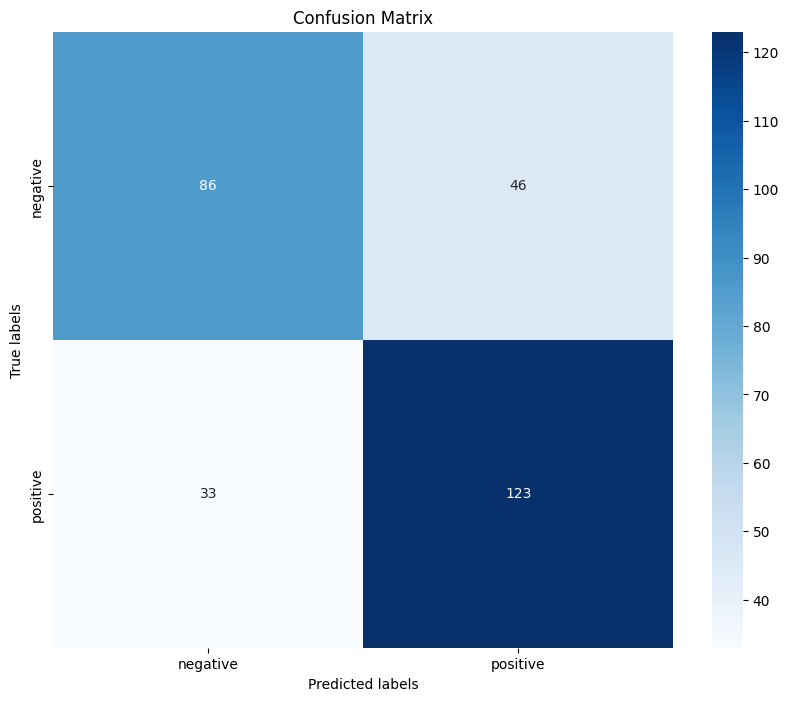

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x[columns], x['label'], train_size = 0.8)
y_train = [1 if el == 'negative' else 0 for el in y_train]
xgb_model.fit(x_train, y_train)

y_valid = y_train = [1 if el == 'negative' else 0 for el in y_valid]
y_pred = xgb_model.predict(x_valid)

cm = confusion_matrix(y_valid, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import recall_score
recall = recall_score(y_valid, y_pred, average = 'weighted')
recall

0.7256944444444444

In [ ]:
from sklearn.metrics import precision_score
precision = precision_score(y_valid, y_pred, average = 'weighted')
precision

0.7254632622279682

In [ ]:
x.columns

Index(['F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_sma3_stddevNorm', 'mfcc2_

In [ ]:
positives = [x['F0semitoneFrom27.5Hz_sma3nz_amean'][i] for i in x[x['label'] == 'positive'].index]
sum(positives)/len(positives)

33.41289368898812

In [ ]:
negatives = [x['F0semitoneFrom27.5Hz_sma3nz_amean'][i] for i in x[x['label'] == 'negative'].index]
sum(negatives)/len(negatives)

34.782805040364615

In [ ]:
positives = [x['HNRdBACF_sma3nz_amean'][i] for i in x[x['label'] == 'positive'].index]
sum(positives)/len(positives)

5.956545579017858

In [ ]:
negatives = [x['HNRdBACF_sma3nz_amean'][i] for i in x[x['label'] == 'negative'].index]
sum(negatives)/len(negatives)

5.460205995156251

In [ ]:
positives = [x['shimmerLocaldB_sma3nz_amean'][i] for i in x[x['label'] == 'positive'].index]
sum(positives)/len(positives)

1.2216461900297635

In [ ]:
negatives = [x['shimmerLocaldB_sma3nz_amean'][i] for i in x[x['label'] == 'negative'].index]
sum(negatives)/len(negatives)

1.2599780001822924

In [ ]:
positives = [x['jitterLocal_sma3nz_amean'][i] for i in x[x['label'] == 'positive'].index]
sum(positives)/len(positives)

0.03353160567678574

In [ ]:
negatives = [x['jitterLocal_sma3nz_amean'][i] for i in x[x['label'] == 'negative'].index]
sum(negatives)/len(negatives)

0.035676607714192746

In [ ]:
positives = [x['jitterLocal_sma3nz_amean'][i] for i in x[x['label'] == 'positive'].index]
sum(positives)/len(positives)

In [ ]:
negatives = [x['jitterLocal_sma3nz_amean'][i] for i in x[x['label'] == 'negative'].index]
sum(negatives)/len(negatives)